# Student Math Misconception Classification

# Automated Classification of Student Mathematical Misconceptions Using a Fine-Tuned ELECTRA Model with LLM-based Data Augmentation and Revision

This project presents a comprehensive, multi-stage framework for the automated classification of student mathematical misconceptions from free-text explanations. Addressing the critical challenge of severe class imbalance inherent in educational datasets, this worksheet details a pipeline that leverages a Large Language Model (`Qwen/Qwen2.5-0.5B-Instruct`) for sophisticated data preprocessing. The initial stages involve programmatic data revision to correct encoding errors and format mathematical notation, followed by an LLM-based evaluation to determine the correctness of both the student's multiple-choice answer and their written justification. To create a robust training set, synthetic data is generated to augment 35 underrepresented misconception categories, thereby balancing the class distribution. The final, enhanced dataset is then used to fine-tune a `google/electra-base-discriminator` model for the multi-class classification task, demonstrating a novel approach to improving model performance by systematically enhancing data quality and quantity.


## Overview
This notebook implements a complete pipeline for predicting student math misconceptions using a **composite label approach**. Instead of predicting components separately, the model predicts a single label that combines:
- Answer Correctness (True/False)
- Category (Correct/Neither/Misconception)
- Misconception Name (34 misconceptions + NA)

## Pipeline Steps
1. Import libraries and setup
2. Configure parameters
3. Setup API credentials
4. Data Exploration
5. Load and prepare data with composite labels
6. Revise student explanations using Qwen
7. Analyze class distribution
8. Data augmentation
9. Prepare data for fine-tuning
10. Load ELECTRA model
11. Train model
12. Validation and evaluation

## STEP 1: Import Required Libraries

In [2]:
"""
STEP 1: IMPORT REQUIRED LIBRARIES
================================================================================
This cell imports all necessary Python libraries for data manipulation, machine
learning model training, and natural language processing tasks.
================================================================================
"""
import os
import json
import warnings
import random
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from google.colab import userdata
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model
from sentence_transformers import SentenceTransformer
from datasets import Dataset
from google.colab import files

# Suppress warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✓ All imports successful")

✓ All imports successful


## STEP 2: Configuration

In [3]:
"""
STEP 2: CONFIGURATION
================================================================================
Centralizes all hyperparameters, file paths, and model specifications.

Model predicts composite labels combining:
- Answer Correctness (True/False)
- Category (Correct/Neither/Misconception)
- Misconception Name (34 misconceptions + NA)
================================================================================
"""

class Config:
    # --- Credentials for API Access ---
    KAGGLE_USERNAME = userdata.get('Secret_Key_1')
    KAGGLE_KEY = userdata.get('Secret_Key_2')
    HF_TOKEN = userdata.get('Secret_Key_3')

    # --- Global Data Settings ---
    DATA_DIR = "/content/data"
    OUTPUT_DIR = "/content/outputs"
    TEST_SIZE = 1
    VAL_SIZE = 1

    # --- Explanation Revision Model Configuration ---
    class Revision:
        MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
        BATCH_SIZE = 1024
        MAX_LENGTH = 1024
        MAX_NEW_TOKENS = 200

    # --- Data Augmentation Model Configuration ---
    class Augmentation:
        MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
        BATCH_SIZE = 1024
        MAX_LENGTH = 1024
        MAX_NEW_TOKENS = 200
        MAX_AUGMENT_PER_CLASS = 2000
        AUGMENT_MINORITY_THRESHOLD = 0.5

    # --- Fine-Tuning Model Configuration ---
    class FineTuning:
        MODEL_NAME = "google/electra-base-discriminator"
        MODEL_SAVE_PATH = "/content/electra_finetuned_composite"
        NUM_LABELS = None  # Set dynamically based on unique composite labels
        NUM_EPOCHS = 35
        BATCH_SIZE = 128
        GRADIENT_ACCUMULATION = 2
        LEARNING_RATE = 2e-5
        WEIGHT_DECAY = 0.01
        MAX_LENGTH = 256

    # --- Create Required Directories ---
    os.makedirs(DATA_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(FineTuning.MODEL_SAVE_PATH, exist_ok=True)

# Display configuration
print("="*70)
print("CONFIGURATION LOADED")
print("="*70)
print(f"Revision & Augmentation Model: {Config.Revision.MODEL_NAME}")
print(f"Fine-Tuning Classification Model: {Config.FineTuning.MODEL_NAME}")
print(f"Fine-Tuning Epochs: {Config.FineTuning.NUM_EPOCHS}")
print(f"Fine-Tuning Effective Batch Size: {Config.FineTuning.BATCH_SIZE * Config.FineTuning.GRADIENT_ACCUMULATION}")
print("="*70 + "\n")

CONFIGURATION LOADED
Revision & Augmentation Model: Qwen/Qwen2.5-0.5B-Instruct
Fine-Tuning Classification Model: google/electra-base-discriminator
Fine-Tuning Epochs: 35
Fine-Tuning Effective Batch Size: 256



## STEP 3: Setup Kaggle & Hugging Face API

In [4]:
"""
STEP 3: SETUP KAGGLE & HUGGING FACE API
================================================================================
Configures API credentials for:
1. Kaggle: Downloads competition dataset
2. Hugging Face: Accesses pre-trained language models
================================================================================
"""

# Configure Kaggle API
print("Setting up Kaggle API...")
os.makedirs('/root/.kaggle', exist_ok=True)
kaggle_creds = {
    "username": Config.KAGGLE_USERNAME,
    "key": Config.KAGGLE_KEY
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)
os.chmod('/root/.kaggle/kaggle.json', 600)
print("✓ Kaggle configured")

# Configure Hugging Face
os.environ['HF_TOKEN'] = Config.HF_TOKEN
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = '1'
print("✓ Hugging Face token set")

Setting up Kaggle API...
✓ Kaggle configured
✓ Hugging Face token set


## STEP 4: Data Exploration

In [5]:
"""
STEP 4: DOWNLOAD COMPETITION DATASET
================================================================================
Downloads the competition data from Kaggle.
================================================================================
"""

print("Downloading competition data...")
!kaggle competitions download -c map-charting-student-math-misunderstandings -p {Config.DATA_DIR}
!unzip -q -o {Config.DATA_DIR}/map-charting-student-math-misunderstandings.zip -d {Config.DATA_DIR}
print("✓ Dataset downloaded")
print("\nFiles:")
!ls -lh {Config.DATA_DIR}/*.csv

  0% 0.00/815k [00:00<?, ?B/s]
100% 815k/815k [00:00<00:00, 1.25GB/s]
✓ Dataset downloaded

Files:
-rw-r--r-- 1 root root  240 Jul  7 02:08 /content/data/sample_submission.csv
-rw-r--r-- 1 root root  687 Jul  7 02:08 /content/data/test.csv
-rw-r--r-- 1 root root 7.6M Jul  7 02:09 /content/data/train.csv


COLUMN NAMES
['row_id', 'QuestionId', 'QuestionText', 'MC_Answer', 'StudentExplanation', 'Category', 'Misconception']

DATASET SHAPE
Rows: 36,696, Columns: 7

DATA TYPES
row_id                 int64
QuestionId             int64
QuestionText          object
MC_Answer             object
StudentExplanation    object
Category              object
Misconception         object
dtype: object

NULL VALUES
               Null_Count  Null_Percentage
Misconception       26836        73.130586

UNIQUE VALUES PER COLUMN
row_id: 36,696 unique values
QuestionId: 15 unique values
QuestionText: 15 unique values
MC_Answer: 49 unique values
StudentExplanation: 35,726 unique values
Category: 6 unique values
Misconception: 35 unique values

DESCRIPTIVE STATISTICS
                      count unique  \
row_id              36696.0    NaN   
QuestionId          36696.0    NaN   
QuestionText          36696     15   
MC_Answer             36696     49   
StudentExplanation    36696  35726   
Category            

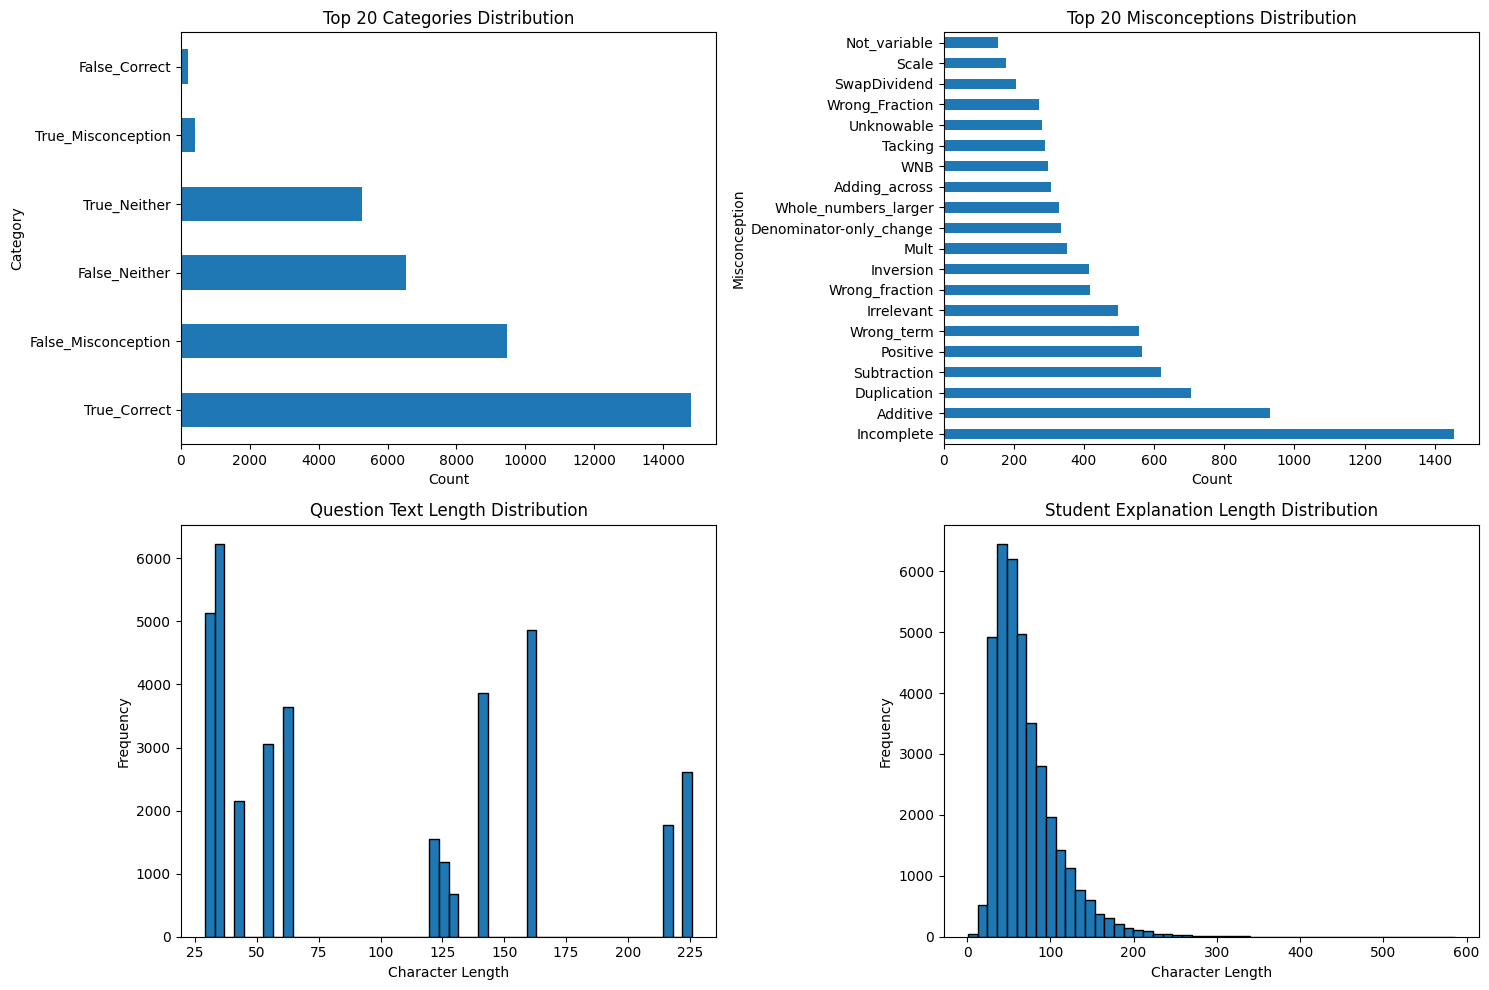

SAMPLE ROWS
   row_id  QuestionId                                       QuestionText  \
0       0       31772  What fraction of the shape is not shaded? Give...   
1       1       31772  What fraction of the shape is not shaded? Give...   
2       2       31772  What fraction of the shape is not shaded? Give...   
3       3       31772  What fraction of the shape is not shaded? Give...   
4       4       31772  What fraction of the shape is not shaded? Give...   
5       5       31772  What fraction of the shape is not shaded? Give...   
6       6       31772  What fraction of the shape is not shaded? Give...   
7       7       31772  What fraction of the shape is not shaded? Give...   
8       8       31772  What fraction of the shape is not shaded? Give...   
9       9       31772  What fraction of the shape is not shaded? Give...   

           MC_Answer                                 StudentExplanation  \
0  \( \frac{1}{3} \)                  0ne third is equal to tree nineth   
1

In [11]:
"""
DATA EXPLORATION - train.csv
================================================================================
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv(f"{Config.DATA_DIR}/train.csv")

print("="*80)
print("COLUMN NAMES")
print("="*80)
print(train.columns.tolist())
print()

print("="*80)
print("DATASET SHAPE")
print("="*80)
print(f"Rows: {train.shape[0]:,}, Columns: {train.shape[1]}")
print()

print("="*80)
print("DATA TYPES")
print("="*80)
print(train.dtypes)
print()

print("="*80)
print("NULL VALUES")
print("="*80)
null_counts = train.isnull().sum()
null_pct = (train.isnull().sum() / len(train)) * 100
null_summary = pd.DataFrame({
    'Null_Count': null_counts,
    'Null_Percentage': null_pct
})
print(null_summary[null_summary['Null_Count'] > 0])
print()

print("="*80)
print("UNIQUE VALUES PER COLUMN")
print("="*80)
for col in train.columns:
    print(f"{col}: {train[col].nunique():,} unique values")
print()

print("="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
print(train.describe(include='all').T)
print()

print("="*80)
print("UNIQUE VALUES - Category")
print("="*80)
print(f"Total unique categories: {train['Category'].nunique()}")
print(train['Category'].value_counts())
print()

print("="*80)
print("UNIQUE VALUES - Misconception")
print("="*80)
print(f"Total unique misconceptions: {train['Misconception'].nunique()}")
print(train['Misconception'].value_counts())
print()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Category distribution
train['Category'].value_counts().head(20).plot(kind='barh', ax=axes[0, 0])
axes[0, 0].set_title('Top 20 Categories Distribution')
axes[0, 0].set_xlabel('Count')

# Misconception distribution
train['Misconception'].value_counts().head(20).plot(kind='barh', ax=axes[0, 1])
axes[0, 1].set_title('Top 20 Misconceptions Distribution')
axes[0, 1].set_xlabel('Count')

# Text length distributions
train['QuestionText_len'] = train['QuestionText'].str.len()
train['StudentExplanation_len'] = train['StudentExplanation'].str.len()

axes[1, 0].hist(train['QuestionText_len'], bins=50, edgecolor='black')
axes[1, 0].set_title('Question Text Length Distribution')
axes[1, 0].set_xlabel('Character Length')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(train['StudentExplanation_len'], bins=50, edgecolor='black')
axes[1, 1].set_title('Student Explanation Length Distribution')
axes[1, 1].set_xlabel('Character Length')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("="*80)
print("SAMPLE ROWS")
print("="*80)
print(train.head(10))

In [15]:
"""
ENCODING ERROR DETECTION
================================================================================
"""

# Read with Latin-1 to preserve encoding errors
train_raw = pd.read_csv(f"{Config.DATA_DIR}/train.csv", encoding='latin-1')

# Common UTF-8/Latin-1 encoding error patterns
encoding_patterns = {
    'Â': 'Latin-1 misread UTF-8',
    'Ã': 'Accented character error',
    'â': 'Quote/dash error',
    'Ã©': 'é encoding error',
    'Ã¡': 'á encoding error',
    'Ã³': 'ó encoding error',
    'â€™': 'Apostrophe error',
    'â€"': 'Em dash error',
    'â€œ': 'Quote error'
}

# Detect each pattern
for pattern, description in encoding_patterns.items():
    train_raw[f'has_{pattern}'] = train_raw['StudentExplanation'].str.contains(pattern, na=False, regex=False)

# Overall flag
pattern_cols = [col for col in train_raw.columns if col.startswith('has_')]
train_raw['has_any_encoding_error'] = train_raw[pattern_cols].any(axis=1)

print("="*80)
print("ENCODING ERROR SUMMARY")
print("="*80)
print(f"Total rows with encoding errors: {train_raw['has_any_encoding_error'].sum():,}")
print(f"Percentage: {(train_raw['has_any_encoding_error'].sum() / len(train_raw)) * 100:.2f}%\n")

print("Pattern breakdown:")
for pattern, description in encoding_patterns.items():
    count = train_raw[f'has_{pattern}'].sum()
    if count > 0:
        print(f"  {pattern:10} ({description}): {count:,} rows")

# Show diverse examples
print("\n" + "="*80)
print("EXAMPLES (first 15)")
print("="*80)

examples = train_raw[train_raw['has_any_encoding_error']].head(15)
for idx, explanation in examples['StudentExplanation'].items():
    print(f"\nRow {idx}:")
    print(f"{explanation}")
    print("-" * 80)

ENCODING ERROR SUMMARY
Total rows with encoding errors: 1,202
Percentage: 3.28%

Pattern breakdown:
  Â          (Latin-1 misread UTF-8): 21 rows
  Ã          (Accented character error): 232 rows
  â          (Quote/dash error): 961 rows
  Ã¡         (á encoding error): 3 rows
  Ã³         (ó encoding error): 2 rows

EXAMPLES (first 15)

Row 47:
3                                                              1
Â¬   are shaded which converts to       Â¬
9                                                               3
--------------------------------------------------------------------------------

Row 67:
3 ninths isnât shaded and 1 third is the simplest form
--------------------------------------------------------------------------------

Row 68:
3 ninths isnât shaded and 1 third is the simplest form.
--------------------------------------------------------------------------------

Row 171:
3/9 arenât shaded but you can simplify it you get 1/3
------------------------------------

## STEP 5: Load and Prepare Data with Composite Labels

In [ ]:
"""
STEP 5: LOAD AND PREPARE DATA WITH COMPOSITE LABELS
================================================================================
Creates composite labels combining Category and Misconception.

COMPOSITE LABEL FORMAT: {Answer_Correctness}_{Category}:{Misconception}
Examples:
  - True_Correct:NA
  - False_Misconception:Adds rather than subtracts
  - True_Neither:NA
================================================================================
"""

print("Loading train.csv...")
full_data = pd.read_csv(f"{Config.DATA_DIR}/train.csv")
print(f"  Total samples: {len(full_data):,}")

# --- Create Composite Labels ---
print("\nCreating composite labels...")
full_data['Misconception'] = full_data['Misconception'].fillna('NA')
full_data['CompositeLabel'] = full_data['Category'] + ':' + full_data['Misconception']

# Get unique composite labels
unique_composite_labels = sorted(full_data['CompositeLabel'].unique())
print(f"  Found {len(unique_composite_labels)} unique composite labels")

# Create mapping dictionaries
composite_label_to_id = {label: idx for idx, label in enumerate(unique_composite_labels)}
id_to_composite_label = {idx: label for idx, label in enumerate(unique_composite_labels)}

# Map to numeric IDs
full_data['CompositeLabelId'] = full_data['CompositeLabel'].map(composite_label_to_id)

# Update Config
Config.FineTuning.NUM_LABELS = len(unique_composite_labels)
print(f"  Updated NUM_LABELS: {Config.FineTuning.NUM_LABELS}")

# --- Parse components for analysis ---
def split_category(category_str):
    if pd.isna(category_str):
        return None, None
    parts = category_str.split('_', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return None, None

full_data[['Answer_Correctness', 'Category_Type']] = \
    full_data['Category'].apply(lambda x: pd.Series(split_category(x)))

# --- Helper function ---
def create_query_string(row):
    return (f"Question: {row.get('QuestionText', '')}\n"
            f"Student Answer: {row.get('MC_Answer', '')}\n"
            f"Student Explanation: {row.get('StudentExplanation', '')}")

# Initialize tracking columns
full_data['is_augmented'] = False
full_data['original_id'] = full_data.index

print("✓ Preprocessing complete")
print(f"\nComposite label distribution (top 10):")
print(full_data['CompositeLabel'].value_counts().head(10))
print(f"\nSample composite labels:")
for label in list(unique_composite_labels)[:5]:
    print(f"  {label}")

Loading train.csv...
  Total samples: 36,696

Creating composite labels...
  Found 65 unique composite labels
  Updated NUM_LABELS: 65
✓ Preprocessing complete

Composite label distribution (top 10):
CompositeLabel
True_Correct:NA                       14802
False_Neither:NA                       6542
True_Neither:NA                        5265
False_Misconception:Incomplete         1446
False_Misconception:Additive            891
False_Misconception:Duplication         698
False_Misconception:Subtraction         618
False_Misconception:Positive            564
False_Misconception:Wrong_term          550
False_Misconception:Wrong_fraction      412
Name: count, dtype: int64

Sample composite labels:
  False_Correct:NA
  False_Misconception:Adding_across
  False_Misconception:Adding_terms
  False_Misconception:Additive
  False_Misconception:Base_rate


## STEP 6: Revise Student Explanations Using Qwen

In [ ]:
"""
STEP 6: REVISE STUDENT EXPLANATIONS USING QWEN
================================================================================
This cell corrects encoding errors and formats mathematical notation in student
explanations using the Qwen language model. The revision process:

1. Identifies and corrects mojibake (encoding corruption)
2. Fixes grammatical and spelling errors
3. Formats mathematical expressions in LaTeX notation
4. Preserves the student's original reasoning and voice

This preprocessing step improves downstream classification accuracy by ensuring
consistent text formatting across all samples.
================================================================================
"""

print("="*70)
print("STEP 6: Revising Student Explanations with Qwen")
print("="*70)

# --- Load Qwen Model for Text Revision ---
print(f"Loading revision model: {Config.Revision.MODEL_NAME}")
revision_tokenizer = AutoTokenizer.from_pretrained(
    Config.Revision.MODEL_NAME,
    trust_remote_code=True
)
revision_model = AutoModelForCausalLM.from_pretrained(
    Config.Revision.MODEL_NAME,
    device_map="auto",
    dtype=torch.bfloat16,
    trust_remote_code=True
).eval()
print("✓ Revision model loaded")

# --- Define Revision Prompt Template ---
REVISION_PROMPT_TEMPLATE = """You are a text restoration engine. Your only function is to correct objective errors in the provided text according to the rules below.

**Primary Directive:**
Your highest priority is to preserve the student's original phrasing, sentence structure, and logical flow. You will only fix demonstrable errors. You will not "improve" or "clarify" the text.

**Permitted Actions:**

1.  **Fix Character Encoding:** Replace corrupted characters (e.g., `â^š`, `Ã—`) with their correct equivalents.
2.  **Correct Objective Errors:** Fix unambiguous spelling mistakes (e.g., `ther` -> `there`), grammatical errors (e.g., `there is 9` -> `there are 9`), and punctuation.

---

### **Forbidden Transformations: Crucial Rules**

You are strictly forbidden from making the following types of changes. These actions violate your primary directive.

**1. Do NOT Rephrase or Restructure Sentences.**
* **Original:** `3 goes into 9 three times which makes it one third`
* **FORBIDDEN REVISION:** `9 divided by 3 equals 3, so it can also be written as 1/3.`
    * **Reason:** This changes the student's informal phrasing into a formal mathematical statement. The original structure and voice must be kept.

**2. Do NOT Add Explanatory or Introductory Text.**
* **Original:** `1 out of every 3 isn't coloured`
* **FORBIDDEN REVISION:** `The answer states that one-third of the items are not colored.`
    * **Reason:** The phrase "The answer states that..." is an addition that was not in the original text.

**3. Do NOT Change the Student's Logic or Voice.**
* **Original:** `1 third because 6 over 9 is 2 thirds and 1 third is not shaded`
* **FORBIDDEN REVISION:** `The fraction 6/9 simplifies to 2/3. Since 1/3 is not shaded, it means that 1/3 of the whole is not shaded. Therefore, the answer is 1/3.`
    * **Reason:** This expands a simple, fragmented thought into a multi-sentence, formal explanation. It fundamentally alters the student's voice and intent.

---

**Strict Output Format:**
Your final output must be **only** the corrected text and nothing else.
* Do **NOT** include any introductory phrases (e.g., "Here is the corrected version:").
* Do **NOT** wrap the text in quotation marks (`"`).
* Do **NOT** add any notes or explanations about your changes.

**Revise the following text:**
`{explanation}`
"""

# --- Batch Revision Function ---
def revise_explanations_batch(explanations, model, tokenizer):
    """
    Processes a batch of student explanations through the Qwen model for revision.

    Args:
        explanations: List of raw student explanation strings
        model: Qwen language model
        tokenizer: Corresponding tokenizer

    Returns:
        List of revised explanation strings
    """
    prompts = [REVISION_PROMPT_TEMPLATE.format(explanation=exp)
               for exp in explanations]
    messages = [[{"role": "user", "content": prompt}] for prompt in prompts]

    # Apply chat template formatting
    formatted_prompts = [
        tokenizer.apply_chat_template(
            message,
            tokenize=False,
            add_generation_prompt=True
        ) for message in messages
    ]

    # Tokenize batch for model input
    inputs = tokenizer(
        formatted_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=Config.Revision.MAX_LENGTH
    ).to(model.device)

    # Simplified generation parameters
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=Config.Revision.MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode only the newly generated tokens
    input_len = inputs['input_ids'].shape[1]
    new_tokens = outputs[:, input_len:]
    decoded = tokenizer.batch_decode(new_tokens, skip_special_tokens=True)
    return [d.strip() for d in decoded]

# --- Apply Revision to All Explanations ---
print("\nApplying revision to 'StudentExplanation' column...")
revised_explanations = []
batch_size = Config.Revision.BATCH_SIZE
explanations_to_revise = full_data['StudentExplanation'].fillna('').tolist()

for i in tqdm(range(0, len(explanations_to_revise), batch_size),
              desc="Revising Batches"):
    batch = explanations_to_revise[i:i+batch_size]
    revised_batch = revise_explanations_batch(batch, revision_model,
                                               revision_tokenizer)
    revised_explanations.extend(revised_batch)

full_data['StudentExplanation'] = revised_explanations
print(f"✓ Revised {len(full_data):,} explanations.")

# --- Save Original vs Revised Comparison ---
print("\nSaving comparison CSV...")
comparison_df = pd.DataFrame({
    'Original': explanations_to_revise,
    'Revised': revised_explanations
})
comparison_df.to_csv('original_vs_revised_explanations.csv', index=False)
print(f"✓ Saved comparison to 'original_vs_revised_explanations.csv' ({len(comparison_df):,} rows)")

# --- Download file in Colab ---
from google.colab import files
files.download('original_vs_revised_explanations.csv')
print("✓ Download started - check your browser's download folder")

# --- Clean Up GPU Memory ---
del revision_model, revision_tokenizer
torch.cuda.empty_cache()
print("✓ Revision model unloaded and GPU memory cleared.")

STEP 6: Revising Student Explanations with Qwen
Loading revision model: Qwen/Qwen2.5-0.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✓ Revision model loaded

Applying revision to 'StudentExplanation' column...


Revising Batches:   0%|          | 0/36 [00:00<?, ?it/s]

✓ Revised 36,696 explanations.

Saving comparison CSV...
✓ Saved comparison to 'original_vs_revised_explanations.csv' (36,696 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download started - check your browser's download folder
✓ Revision model unloaded and GPU memory cleared.


## STEP 7: Analyze Class Distribution

In [ ]:
"""
STEP 7: ANALYZE CLASS DISTRIBUTION
================================================================================
Analyzes the dataset and prepares for augmentation.
================================================================================
"""

# Preserve original data for validation
original_data_for_validation = full_data.copy()
print(f"✓ Original data preserved: {len(original_data_for_validation):,} samples")

# Prepare for augmentation
data_for_augmentation = full_data.copy()
print(f"✓ Data prepared for augmentation: {len(data_for_augmentation):,} samples")

# Analyze class imbalance
print("\nClass Imbalance Analysis (Composite Labels):")
composite_label_counts = data_for_augmentation['CompositeLabelId'].value_counts().sort_index()
print(f"  Median samples/class: {composite_label_counts.median():.0f}")
print(f"  Max samples/class: {composite_label_counts.max()}")
print(f"  Min samples/class: {composite_label_counts.min()}")
if composite_label_counts.min() > 0:
    print(f"  Imbalance ratio: {composite_label_counts.max() / composite_label_counts.min():.1f}:1")

train_df = data_for_augmentation

✓ Original data preserved: 36,696 samples
✓ Data prepared for augmentation: 36,696 samples

Class Imbalance Analysis (Composite Labels):
  Median samples/class: 50
  Max samples/class: 14802
  Min samples/class: 1
  Imbalance ratio: 14802.0:1


## STEP 8: Data Augmentation with Composite Labels

In [ ]:
"""
STEP 8: DATA AUGMENTATION WITH COMPOSITE LABELS
================================================================================
Generates synthetic student explanations to balance classes.
================================================================================
"""

print("="*70)
print("STEP 8: Data Augmentation with Qwen")
print("="*70)

# Load augmentation model
print(f"\nLoading augmentation model: {Config.Augmentation.MODEL_NAME}")
aug_tokenizer = AutoTokenizer.from_pretrained(Config.Augmentation.MODEL_NAME,
                                               trust_remote_code=True)
aug_model = AutoModelForCausalLM.from_pretrained(
    Config.Augmentation.MODEL_NAME,
    device_map="auto",
    torch_dtype="auto",
    trust_remote_code=True
).eval()
if aug_tokenizer.pad_token is None:
    aug_tokenizer.pad_token = aug_tokenizer.eos_token
print("✓ Augmentation model loaded")

# Prepare prompts
all_prompts = []
all_template_rows = []
target_sample_count = Config.Augmentation.MAX_AUGMENT_PER_CLASS
print(f"\nTarget: {target_sample_count:,} samples per class")

composite_label_counts = train_df['CompositeLabelId'].value_counts()

for label_id, current_count in tqdm(composite_label_counts.items(), desc="Preparing Prompts"):
    if current_count >= target_sample_count:
        continue

    num_to_generate = target_sample_count - current_count
    class_df = train_df[train_df['CompositeLabelId'] == label_id]
    template_samples = class_df.sample(n=num_to_generate, replace=True)
    all_template_rows.extend(template_samples.to_dict('records'))

    for _, template_row in template_samples.iterrows():
        composite_label = template_row['CompositeLabel']
        answer_correct = template_row['Answer_Correctness']
        category_type = template_row['Category_Type']
        misconception = template_row['Misconception']

        prompt = (f"You are simulating a student explaining their mathematical reasoning. "
                  f"Generate a NEW, unique student explanation based on this information:\n\n"
                  f"Question: {template_row['QuestionText']}\n"
                  f"Answer chosen: {template_row['MC_Answer']}\n"
                  f"Answer is: {answer_correct}\n"
                  f"Explanation type: {category_type}\n")

        if misconception != 'NA':
            prompt += f"Misconception: {misconception}\n"

        prompt += ("\nWrite ONLY the student's new explanation in 1-2 sentences. "
                   "Make it realistic and reflect the pattern described above.")

        all_prompts.append(prompt)

print(f"✓ Prepared {len(all_prompts):,} augmentation prompts")

# Batch generation
augmented_rows = []
batch_size = Config.Augmentation.BATCH_SIZE

for i in tqdm(range(0, len(all_prompts), batch_size), desc="Generating Batches"):
    batch_prompts = all_prompts[i:i+batch_size]
    batch_templates = all_template_rows[i:i+batch_size]

    messages = [[{"role": "user", "content": prompt}] for prompt in batch_prompts]

    formatted_prompts = [
        aug_tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
        for message in messages
    ]

    inputs = aug_tokenizer(
        formatted_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(aug_model.device)

    with torch.no_grad():
        outputs = aug_model.generate(
            **inputs,
            max_new_tokens=Config.Augmentation.MAX_NEW_TOKENS,
            do_sample=True,
            top_p=0.85,
            temperature=0.5,
            pad_token_id=aug_tokenizer.eos_token_id
        )

    input_len = inputs['input_ids'].shape[1]
    new_tokens = outputs[:, input_len:]
    decoded = aug_tokenizer.batch_decode(new_tokens, skip_special_tokens=True)

    for template, explanation in zip(batch_templates, decoded):
        new_row = template.copy()
        new_row['StudentExplanation'] = explanation.strip()
        new_row['is_augmented'] = True
        augmented_rows.append(new_row)

print(f"✓ Generated {len(augmented_rows):,} augmented samples")

# Finalize dataset
if augmented_rows:
    augmented_df = pd.DataFrame(augmented_rows)
    augmented_df['QueryString'] = augmented_df.progress_apply(create_query_string, axis=1)
    train_df = pd.concat([train_df, augmented_df], ignore_index=True)
    train_df = shuffle(train_df, random_state=42).reset_index(drop=True)

print(f"\nAugmentation complete. Total training samples: {len(train_df):,}")
new_counts = train_df['CompositeLabelId'].value_counts()
print(f"  New Min/Max samples per class: {new_counts.min()}/{new_counts.max()}")

# Clean up
del aug_model, aug_tokenizer
torch.cuda.empty_cache()
print("✓ Augmentation model unloaded")

STEP 8: Data Augmentation with Qwen

Loading augmentation model: Qwen/Qwen2.5-0.5B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


✓ Augmentation model loaded

Target: 2,000 samples per class


Preparing Prompts: 0it [00:00, ?it/s]

✓ Prepared 113,913 augmentation prompts


Generating Batches:   0%|          | 0/112 [00:00<?, ?it/s]

✓ Generated 113,913 augmented samples


  0%|          | 0/113913 [00:00<?, ?it/s]


Augmentation complete. Total training samples: 150,609
  New Min/Max samples per class: 2000/14802
✓ Augmentation model unloaded


## STEP 9: Prepare Data for Fine-Tuning

In [ ]:
"""
STEP 9: PREPARE DATA FOR FINE-TUNING
================================================================================
Tokenizes data and creates HuggingFace Dataset objects.
================================================================================
"""

print("Preparing data for fine-tuning...")

# Define training and validation sets
train_final = train_df.copy()
val_final = original_data_for_validation.copy()

print(f"\n✓ Data split:")
print(f"  Training: {len(train_final):,} samples")
print(f"  Validation: {len(val_final):,} samples")

# Create labels
train_final['label'] = train_final['CompositeLabelId'].astype(int)
val_final['label'] = val_final['CompositeLabelId'].astype(int)

print(f"\n✓ Label range: {train_final['label'].min()} to {train_final['label'].max()}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(Config.FineTuning.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["QuestionText"],
        examples["StudentExplanation"],
        padding="max_length",
        truncation=True,
        max_length=Config.FineTuning.MAX_LENGTH
    )

# Convert to HuggingFace Datasets
print("\nConverting to HuggingFace Dataset format...")
train_hf_dataset = Dataset.from_pandas(
    train_final[['QuestionText', 'StudentExplanation', 'label']]
)
val_hf_dataset = Dataset.from_pandas(
    val_final[['QuestionText', 'StudentExplanation', 'label']]
)

# Tokenize
print("Tokenizing datasets...")
tokenized_train_dataset = train_hf_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_hf_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)
tokenized_val_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)

print("\n✓ Datasets ready for fine-tuning")
print(f"  Training samples: {len(tokenized_train_dataset):,}")
print(f"  Validation samples: {len(tokenized_val_dataset):,}")

Preparing data for fine-tuning...

✓ Data split:
  Training: 150,609 samples
  Validation: 36,696 samples

✓ Label range: 0 to 64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


Converting to HuggingFace Dataset format...
Tokenizing datasets...


Map:   0%|          | 0/150609 [00:00<?, ? examples/s]

Map:   0%|          | 0/36696 [00:00<?, ? examples/s]


✓ Datasets ready for fine-tuning
  Training samples: 150,609
  Validation samples: 36,696


## STEP 10: Load ELECTRA Model

In [ ]:
"""
STEP 10: LOAD ELECTRA MODEL FOR COMPOSITE LABEL CLASSIFICATION
================================================================================
Initializes ELECTRA with a classification head for composite label prediction.
================================================================================
"""

print("="*70)
print("STEP 10: LOADING ELECTRA FOR COMPOSITE LABEL CLASSIFICATION")
print("="*70)

# Create label mappings
id2label = {idx: label for idx, label in enumerate(sorted(full_data['CompositeLabel'].unique()))}
label2id = {label: idx for idx, label in id2label.items()}

print(f"\nLabel mapping created:")
print(f"  Total labels: {len(id2label)}")
print(f"  Sample mappings:")
for idx in list(id2label.keys())[:5]:
    print(f"    {idx}: {id2label[idx]}")

# Load ELECTRA
model = AutoModelForSequenceClassification.from_pretrained(
    Config.FineTuning.MODEL_NAME,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

print(f"\n✓ Loaded {Config.FineTuning.MODEL_NAME}")
print(f"   Classification head: 768 → {len(id2label)} composite labels")

STEP 10: LOADING ELECTRA FOR COMPOSITE LABEL CLASSIFICATION

Label mapping created:
  Total labels: 65
  Sample mappings:
    0: False_Correct:NA
    1: False_Misconception:Adding_across
    2: False_Misconception:Adding_terms
    3: False_Misconception:Additive
    4: False_Misconception:Base_rate


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Loaded google/electra-base-discriminator
   Classification head: 768 → 65 composite labels


## STEP 11: Train Model

In [ ]:
"""
STEP 11: FINE-TUNE ELECTRA FOR COMPOSITE LABEL CLASSIFICATION
================================================================================
Trains the model using HuggingFace Trainer API.
================================================================================
"""

print("="*70)
print("STEP 11: FINE-TUNING ELECTRA")
print("="*70)

# Define evaluation metrics
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Configure training
training_args = TrainingArguments(
    output_dir=Config.FineTuning.MODEL_SAVE_PATH,
    num_train_epochs=Config.FineTuning.NUM_EPOCHS,
    per_device_train_batch_size=Config.FineTuning.BATCH_SIZE,
    per_device_eval_batch_size=Config.FineTuning.BATCH_SIZE * 2,
    gradient_accumulation_steps=Config.FineTuning.GRADIENT_ACCUMULATION,
    learning_rate=Config.FineTuning.LEARNING_RATE,
    weight_decay=Config.FineTuning.WEIGHT_DECAY,
    optim="adamw_torch",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=25)]
)

# Train
print("\nStarting training...")
trainer.train()
print("✓ Training complete")

# Save model
print("\nSaving model...")
trainer.save_model(Config.FineTuning.MODEL_SAVE_PATH)
tokenizer.save_pretrained(Config.FineTuning.MODEL_SAVE_PATH)

# Save label mappings
label_mappings = {
    'id2label': id2label,
    'label2id': label2id,
    'composite_label_to_id': composite_label_to_id,
    'id_to_composite_label': id_to_composite_label
}
with open(f"{Config.FineTuning.MODEL_SAVE_PATH}/label_mappings.json", 'w') as f:
    json.dump(label_mappings, f, indent=2)

print(f"✓ Model and mappings saved to {Config.FineTuning.MODEL_SAVE_PATH}")

STEP 11: FINE-TUNING ELECTRA

Starting training...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,F1
100,3.346100,2.478321,0.392931,0.230465
200,2.490600,2.012528,0.432472,0.340894
300,1.936800,1.683753,0.520138,0.452942
400,1.600600,1.396380,0.564312,0.496528
500,1.373000,1.293889,0.579872,0.518751
600,1.186100,1.164083,0.615244,0.562807
700,1.027700,1.275975,0.590991,0.556614
800,0.931300,1.048109,0.645220,0.603431
900,0.847700,1.013823,0.652006,0.616326
1000,0.787100,0.992924,0.657974,0.629535


Step,Training Loss,Validation Loss,Accuracy,F1
100,3.346100,2.478321,0.392931,0.230465
200,2.490600,2.012528,0.432472,0.340894
300,1.936800,1.683753,0.520138,0.452942
400,1.600600,1.396380,0.564312,0.496528
500,1.373000,1.293889,0.579872,0.518751
600,1.186100,1.164083,0.615244,0.562807
700,1.027700,1.275975,0.590991,0.556614
800,0.931300,1.048109,0.645220,0.603431
900,0.847700,1.013823,0.652006,0.616326
1000,0.787100,0.992924,0.657974,0.629535


✓ Training complete

Saving model...
✓ Model and mappings saved to /content/electra_finetuned_composite


## STEP 12: Validation and evaluation

In [ ]:
"""
STEP 12: VALIDATION, WEIGHT ANALYSIS, AND COMPOSITE LABEL PARSING
================================================================================
This cell performs:
1. Weight comparison analysis (before vs after fine-tuning)
2. Model validation on the validation dataset
3. Composite label parsing into components
4. COMPREHENSIVE performance evaluation for ALL labels

The weight analysis helps us understand:
- Which layers learned the most during fine-tuning
- How much the model changed from its pre-trained state
- Whether fine-tuning was effective
================================================================================
"""

print("="*70)
print("STEP 12: VALIDATION, WEIGHT ANALYSIS, AND PARSING")
print("="*70)

# ============================================================================
# PART 1: WEIGHT COMPARISON ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("WEIGHT COMPARISON: PRE-TRAINED vs FINE-TUNED")
print("="*70)

# Load pre-trained (original) model for comparison
print("\nLoading original pre-trained model...")
pretrained_model = AutoModelForSequenceClassification.from_pretrained(
    Config.FineTuning.MODEL_NAME,
    num_labels=len(id2label)
)
print("✓ Pre-trained model loaded")

# Load fine-tuned model
print(f"Loading fine-tuned model from: {Config.FineTuning.MODEL_SAVE_PATH}")
trained_model = AutoModelForSequenceClassification.from_pretrained(
    Config.FineTuning.MODEL_SAVE_PATH
)
print("✓ Fine-tuned model loaded")

# Compare weights
print("\nAnalyzing weight changes...\n")

weight_changes = []
layer_stats = {}

for name, pretrained_param in pretrained_model.named_parameters():
    if name in dict(trained_model.named_parameters()):
        finetuned_param = dict(trained_model.named_parameters())[name]

        # Calculate difference
        diff = (finetuned_param.data - pretrained_param.data).abs()

        # Calculate statistics
        mean_diff = diff.mean().item()
        max_diff = diff.max().item()
        std_diff = diff.std().item()

        # Calculate percentage of weights that changed significantly (>1% relative change)
        relative_change = diff / (pretrained_param.data.abs() + 1e-8)
        pct_changed = (relative_change > 0.01).float().mean().item() * 100

        layer_stats[name] = {
            'mean_abs_diff': mean_diff,
            'max_abs_diff': max_diff,
            'std_diff': std_diff,
            'pct_changed': pct_changed,
            'num_params': pretrained_param.numel()
        }

# Display results by layer type
print("Weight Change Analysis by Layer:")
print("-" * 70)

# Group by layer type
layer_groups = {
    'Embedding': [],
    'Encoder (Early)': [],
    'Encoder (Middle)': [],
    'Encoder (Late)': [],
    'Classification Head': []
}

for name, stats in layer_stats.items():
    if 'embeddings' in name:
        layer_groups['Embedding'].append((name, stats))
    elif 'classifier' in name or 'qa_outputs' in name:
        layer_groups['Classification Head'].append((name, stats))
    elif 'encoder.layer' in name or 'layer.' in name:
        # Extract layer number
        import re
        match = re.search(r'layer\.(\d+)', name)
        if match:
            layer_num = int(match.group(1))
            if layer_num < 4:
                layer_groups['Encoder (Early)'].append((name, stats))
            elif layer_num < 8:
                layer_groups['Encoder (Middle)'].append((name, stats))
            else:
                layer_groups['Encoder (Late)'].append((name, stats))

# Print summary statistics for each group
for group_name, layers in layer_groups.items():
    if layers:
        print(f"\n{group_name}:")
        avg_mean_diff = np.mean([s['mean_abs_diff'] for _, s in layers])
        avg_pct_changed = np.mean([s['pct_changed'] for _, s in layers])
        total_params = sum([s['num_params'] for _, s in layers])

        print(f"  Average absolute weight change: {avg_mean_diff:.6f}")
        print(f"  Average % of weights changed: {avg_pct_changed:.2f}%")
        print(f"  Total parameters: {total_params:,}")

# Show ALL layers sorted by change magnitude
print("\n" + "-" * 70)
print("ALL LAYERS SORTED BY WEIGHT CHANGE (Largest to Smallest):")
print("="*70)

sorted_layers = sorted(layer_stats.items(),
                       key=lambda x: x[1]['mean_abs_diff'],
                       reverse=True)

print(f"{'Rank':<6} {'Layer Name':<60} {'Mean Δ':<12} {'% Changed':<12} {'# Params':<12}")
print("-" * 110)

for rank, (name, stats) in enumerate(sorted_layers, 1):
    # Shorten name for display but keep it readable
    display_name = name if len(name) <= 57 else "..." + name[-54:]
    print(f"{rank:<6} {display_name:<60} {stats['mean_abs_diff']:<12.8f} {stats['pct_changed']:<12.2f} {stats['num_params']:<12,}")

# Overall statistics
print("\n" + "="*70)
print("OVERALL MODEL STATISTICS")
print("="*70)
all_mean_diffs = [s['mean_abs_diff'] for s in layer_stats.values()]
all_pct_changed = [s['pct_changed'] for s in layer_stats.values()]
total_params_all = sum([s['num_params'] for s in layer_stats.values()])

print(f"  Total parameters in model: {total_params_all:,}")
print(f"  Total layers analyzed: {len(layer_stats)}")
print(f"  Average weight change across all layers: {np.mean(all_mean_diffs):.6f}")
print(f"  Median weight change: {np.median(all_mean_diffs):.6f}")
print(f"  Std dev of weight changes: {np.std(all_mean_diffs):.6f}")
print(f"  Average % of weights changed: {np.mean(all_pct_changed):.2f}%")
print(f"  Layers with >50% weights changed: {sum(1 for p in all_pct_changed if p > 50)}/{len(all_pct_changed)}")
print(f"  Layers with >10% weights changed: {sum(1 for p in all_pct_changed if p > 10)}/{len(all_pct_changed)}")
print(f"  Layers with <1% weights changed: {sum(1 for p in all_pct_changed if p < 1)}/{len(all_pct_changed)}")

# Clean up pretrained model to free memory
del pretrained_model
torch.cuda.empty_cache()

# ============================================================================
# PART 2: MODEL VALIDATION
# ============================================================================

print("\n" + "="*70)
print("MODEL VALIDATION")
print("="*70)

prediction_trainer = Trainer(model=trained_model)

# Generate predictions
print("\nGenerating predictions on validation dataset...")
predictions_output = prediction_trainer.predict(tokenized_val_dataset)

predicted_labels = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Map to composite labels
predicted_composite_labels = [id2label[label_id] for label_id in predicted_labels]
val_final['Predicted_CompositeLabel'] = predicted_composite_labels

print("✓ Predictions generated")

# ============================================================================
# PART 3: PARSE COMPOSITE LABELS
# ============================================================================

print("\nParsing composite labels into components...")

def parse_composite_label(composite_label):
    """Parse {Answer_Correctness}_{Category}:{Misconception}"""
    if pd.isna(composite_label):
        return None, None, None

    parts = composite_label.split(':', 1)
    if len(parts) != 2:
        return None, None, None

    category_part = parts[0]
    misconception = parts[1]

    cat_parts = category_part.split('_', 1)
    if len(cat_parts) != 2:
        return None, None, None

    answer_correctness = cat_parts[0]
    category = cat_parts[1]

    return answer_correctness, category, misconception

# Parse predicted labels
val_final[['Predicted_AnswerCorrectness', 'Predicted_Category', 'Predicted_Misconception']] = \
    val_final['Predicted_CompositeLabel'].apply(lambda x: pd.Series(parse_composite_label(x)))

# Parse ground truth
val_final[['True_AnswerCorrectness', 'True_Category', 'True_Misconception']] = \
    val_final['CompositeLabel'].apply(lambda x: pd.Series(parse_composite_label(x)))

print("✓ Composite labels parsed successfully")

# ============================================================================
# PART 4: COMPREHENSIVE PERFORMANCE EVALUATION
# ============================================================================

print("\n" + "="*70)
print("PERFORMANCE EVALUATION - SUMMARY")
print("="*70)

# Overall composite label accuracy
composite_accuracy = accuracy_score(
    val_final['CompositeLabel'],
    val_final['Predicted_CompositeLabel']
)

print(f"\n{'OVERALL PERFORMANCE':^70}")
print("-" * 70)
print(f"Composite Label Accuracy: {composite_accuracy:.4f} ({composite_accuracy*100:.2f}%)")
print(f"Total validation samples: {len(val_final):,}")
print(f"Correct predictions: {int(composite_accuracy * len(val_final)):,}")
print(f"Incorrect predictions: {int((1 - composite_accuracy) * len(val_final)):,}")

# Component-wise accuracy
answer_accuracy = accuracy_score(
    val_final['True_AnswerCorrectness'],
    val_final['Predicted_AnswerCorrectness']
)
category_accuracy = accuracy_score(
    val_final['True_Category'],
    val_final['Predicted_Category']
)
misconception_accuracy = accuracy_score(
    val_final['True_Misconception'],
    val_final['Predicted_Misconception']
)

print(f"\n{'COMPONENT-WISE ACCURACY':^70}")
print("-" * 70)
print(f"Answer Correctness (True/False):         {answer_accuracy:.4f} ({answer_accuracy*100:.2f}%)")
print(f"Category (Correct/Neither/Misconception): {category_accuracy:.4f} ({category_accuracy*100:.2f}%)")
print(f"Misconception Name:                       {misconception_accuracy:.4f} ({misconception_accuracy*100:.2f}%)")

# Weighted F1 Score
weighted_f1 = f1_score(
    val_final['CompositeLabel'],
    val_final['Predicted_CompositeLabel'],
    average='weighted',
    zero_division=0
)
macro_f1 = f1_score(
    val_final['CompositeLabel'],
    val_final['Predicted_CompositeLabel'],
    average='macro',
    zero_division=0
)

print(f"\n{'F1-SCORES':^70}")
print("-" * 70)
print(f"Weighted F1-Score: {weighted_f1:.4f} (considers class frequency)")
print(f"Macro F1-Score:    {macro_f1:.4f} (treats all classes equally)")

# ============================================================================
# PART 5: DETAILED PER-LABEL ANALYSIS (ALL LABELS)
# ============================================================================

print("\n" + "="*70)
print("COMPLETE PER-LABEL PERFORMANCE (ALL LABELS)")
print("="*70)

# Get all unique labels sorted by frequency
all_label_counts = val_final['CompositeLabel'].value_counts()
print(f"\nTotal unique composite labels: {len(all_label_counts)}")
print(f"Analyzing performance for each label...\n")

# Create detailed performance dataframe
per_label_performance = []

for label in all_label_counts.index:
    label_data = val_final[val_final['CompositeLabel'] == label]

    # Calculate accuracy for this label
    label_acc = accuracy_score(
        label_data['CompositeLabel'],
        label_data['Predicted_CompositeLabel']
    )

    # Calculate how many times this label was predicted (even if wrong)
    times_predicted = (val_final['Predicted_CompositeLabel'] == label).sum()

    # True positives, false positives, false negatives
    correct_predictions = (label_data['Predicted_CompositeLabel'] == label).sum()
    total_actual = len(label_data)

    # Precision and Recall
    precision = correct_predictions / times_predicted if times_predicted > 0 else 0
    recall = correct_predictions / total_actual if total_actual > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    per_label_performance.append({
        'Label': label,
        'Count': total_actual,
        'Accuracy': label_acc,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Times_Predicted': times_predicted,
        'Correct_Predictions': correct_predictions
    })

# Convert to DataFrame and sort by count (frequency)
per_label_df = pd.DataFrame(per_label_performance).sort_values('Count', ascending=False)

# Display ALL labels
print(f"{'Rank':<6} {'Label':<50} {'Count':<8} {'Acc':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
print("="*110)

for idx, row in per_label_df.iterrows():
    rank = per_label_df.index.get_loc(idx) + 1
    label_display = row['Label'] if len(row['Label']) <= 47 else row['Label'][:44] + "..."

    print(f"{rank:<6} {label_display:<50} {row['Count']:<8} "
          f"{row['Accuracy']:<8.4f} {row['Precision']:<8.4f} "
          f"{row['Recall']:<8.4f} {row['F1_Score']:<8.4f}")

# Summary statistics about label performance
print("\n" + "="*70)
print("LABEL PERFORMANCE STATISTICS")
print("="*70)
print(f"Labels with 100% accuracy: {(per_label_df['Accuracy'] == 1.0).sum()}")
print(f"Labels with >90% accuracy: {(per_label_df['Accuracy'] > 0.90).sum()}")
print(f"Labels with >80% accuracy: {(per_label_df['Accuracy'] > 0.80).sum()}")
print(f"Labels with >50% accuracy: {(per_label_df['Accuracy'] > 0.50).sum()}")
print(f"Labels with <50% accuracy: {(per_label_df['Accuracy'] < 0.50).sum()}")
print(f"Labels with 0% accuracy: {(per_label_df['Accuracy'] == 0.0).sum()}")
print(f"\nMean accuracy across all labels: {per_label_df['Accuracy'].mean():.4f}")
print(f"Median accuracy across all labels: {per_label_df['Accuracy'].median():.4f}")
print(f"Std dev of accuracy: {per_label_df['Accuracy'].std():.4f}")

# ============================================================================
# PART 6: FULL CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*70)
print("SKLEARN CLASSIFICATION REPORT (FULL)")
print("="*70)
print("\nThis report shows Precision, Recall, and F1-Score for ALL labels:\n")
print(classification_report(
    val_final['CompositeLabel'],
    val_final['Predicted_CompositeLabel'],
    zero_division=0,
    digits=4
))

# ============================================================================
# PART 7: COMPONENT CONFUSION MATRICES (FULL)
# ============================================================================

print("\n" + "="*70)
print("CONFUSION MATRICES FOR COMPONENTS")
print("="*70)

# Answer Correctness confusion (Full)
print("\n1. ANSWER CORRECTNESS CONFUSION MATRIX (True vs False):")
print("-" * 70)
answer_cm = pd.crosstab(
    val_final['True_AnswerCorrectness'],
    val_final['Predicted_AnswerCorrectness'],
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)
print(answer_cm)
print(f"\nAnswer Correctness Accuracy: {answer_accuracy:.4f}")

# Category confusion (Full)
print("\n2. CATEGORY CONFUSION MATRIX (Correct/Neither/Misconception):")
print("-" * 70)
category_cm = pd.crosstab(
    val_final['True_Category'],
    val_final['Predicted_Category'],
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)
print(category_cm)
print(f"\nCategory Accuracy: {category_accuracy:.4f}")

# Misconception confusion (showing counts, not full matrix as it would be huge)
print("\n3. MISCONCEPTION ANALYSIS:")
print("-" * 70)
unique_misconceptions = val_final['True_Misconception'].nunique()
print(f"Total unique misconceptions (including NA): {unique_misconceptions}")

misconception_correct = (val_final['True_Misconception'] == val_final['Predicted_Misconception']).sum()
print(f"Correctly predicted misconceptions: {misconception_correct:,} / {len(val_final):,}")
print(f"Misconception Accuracy: {misconception_accuracy:.4f}")

# Show most confused misconceptions
print("\nMost Frequently Confused Misconceptions:")
print("(Where model predicted wrong misconception)")
confused = val_final[val_final['True_Misconception'] != val_final['Predicted_Misconception']]
if len(confused) > 0:
    confusion_pairs = confused.groupby(['True_Misconception', 'Predicted_Misconception']).size()
    confusion_pairs = confusion_pairs.sort_values(ascending=False).head(20)
    print(f"\n{'True Misconception':<40} {'Predicted As':<40} {'Count':<10}")
    print("-" * 90)
    for (true_misc, pred_misc), count in confusion_pairs.items():
        true_display = true_misc if len(true_misc) <= 37 else true_misc[:34] + "..."
        pred_display = pred_misc if len(pred_misc) <= 37 else pred_misc[:34] + "..."
        print(f"{true_display:<40} {pred_display:<40} {count:<10}")

# ============================================================================
# PART 8: ERROR ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

# Breakdown of errors
total_errors = len(val_final) - int(composite_accuracy * len(val_final))
print(f"\nTotal errors: {total_errors:,} out of {len(val_final):,} samples")

# Where do errors come from?
answer_errors = (val_final['True_AnswerCorrectness'] != val_final['Predicted_AnswerCorrectness']).sum()
category_errors = (val_final['True_Category'] != val_final['Predicted_Category']).sum()
misconception_errors = (val_final['True_Misconception'] != val_final['Predicted_Misconception']).sum()

print(f"\nError breakdown by component:")
print(f"  Answer Correctness errors: {answer_errors:,} ({answer_errors/len(val_final)*100:.2f}%)")
print(f"  Category errors: {category_errors:,} ({category_errors/len(val_final)*100:.2f}%)")
print(f"  Misconception errors: {misconception_errors:,} ({misconception_errors/len(val_final)*100:.2f}%)")

# Error patterns
print(f"\nError patterns:")
only_answer_wrong = ((val_final['True_AnswerCorrectness'] != val_final['Predicted_AnswerCorrectness']) &
                     (val_final['True_Category'] == val_final['Predicted_Category']) &
                     (val_final['True_Misconception'] == val_final['Predicted_Misconception'])).sum()

only_category_wrong = ((val_final['True_AnswerCorrectness'] == val_final['Predicted_AnswerCorrectness']) &
                       (val_final['True_Category'] != val_final['Predicted_Category']) &
                       (val_final['True_Misconception'] == val_final['Predicted_Misconception'])).sum()

only_misconception_wrong = ((val_final['True_AnswerCorrectness'] == val_final['Predicted_AnswerCorrectness']) &
                            (val_final['True_Category'] == val_final['Predicted_Category']) &
                            (val_final['True_Misconception'] != val_final['Predicted_Misconception'])).sum()

multiple_wrong = total_errors - only_answer_wrong - only_category_wrong - only_misconception_wrong

print(f"  Only answer correctness wrong: {only_answer_wrong:,}")
print(f"  Only category wrong: {only_category_wrong:,}")
print(f"  Only misconception wrong: {only_misconception_wrong:,}")
print(f"  Multiple components wrong: {multiple_wrong:,}")

# ============================================================================
# PART 9: SAVE ALL RESULTS
# ============================================================================

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save validation results
validation_results_path = f"{Config.OUTPUT_DIR}/validation_results.csv"
val_final.to_csv(validation_results_path, index=False)
print(f"✓ Full validation results saved to: {validation_results_path}")

# Save per-label performance
per_label_path = f"{Config.OUTPUT_DIR}/per_label_performance.csv"
per_label_df.to_csv(per_label_path, index=False)
print(f"✓ Per-label performance saved to: {per_label_path}")

# Save weight change analysis
weight_analysis_path = f"{Config.OUTPUT_DIR}/weight_change_analysis.csv"
weight_df = pd.DataFrame([
    {
        'layer_name': name,
        'mean_abs_diff': stats['mean_abs_diff'],
        'max_abs_diff': stats['max_abs_diff'],
        'std_diff': stats['std_diff'],
        'pct_changed': stats['pct_changed'],
        'num_params': stats['num_params']
    }
    for name, stats in layer_stats.items()
]).sort_values('mean_abs_diff', ascending=False)
weight_df.to_csv(weight_analysis_path, index=False)
print(f"✓ Weight change analysis saved to: {weight_analysis_path}")

# Save confusion matrices
confusion_path = f"{Config.OUTPUT_DIR}/confusion_matrices.txt"
with open(confusion_path, 'w') as f:
    f.write("ANSWER CORRECTNESS CONFUSION MATRIX\n")
    f.write("="*70 + "\n")
    f.write(str(answer_cm) + "\n\n")

    f.write("CATEGORY CONFUSION MATRIX\n")
    f.write("="*70 + "\n")
    f.write(str(category_cm) + "\n\n")
print(f"✓ Confusion matrices saved to: {confusion_path}")

# Save summary statistics
summary_path = f"{Config.OUTPUT_DIR}/performance_summary.txt"
with open(summary_path, 'w') as f:
    f.write("PERFORMANCE SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Overall Composite Label Accuracy: {composite_accuracy:.4f}\n")
    f.write(f"Answer Correctness Accuracy: {answer_accuracy:.4f}\n")
    f.write(f"Category Accuracy: {category_accuracy:.4f}\n")
    f.write(f"Misconception Accuracy: {misconception_accuracy:.4f}\n")
    f.write(f"Weighted F1-Score: {weighted_f1:.4f}\n")
    f.write(f"Macro F1-Score: {macro_f1:.4f}\n\n")
    f.write(f"Total validation samples: {len(val_final):,}\n")
    f.write(f"Total unique labels: {len(all_label_counts)}\n")
    f.write(f"Total errors: {total_errors:,}\n")
print(f"✓ Performance summary saved to: {summary_path}")

print("\n" + "="*70)
print("✓ VALIDATION COMPLETE - ALL RESULTS SAVED")
print("="*70)
print(f"\nOutput files created:")
print(f"  1. {validation_results_path}")
print(f"  2. {per_label_path}")
print(f"  3. {weight_analysis_path}")
print(f"  4. {confusion_path}")
print(f"  5. {summary_path}")

STEP 12: VALIDATION, WEIGHT ANALYSIS, AND PARSING

WEIGHT COMPARISON: PRE-TRAINED vs FINE-TUNED

Loading original pre-trained model...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Pre-trained model loaded
Loading fine-tuned model from: /content/electra_finetuned_composite
✓ Fine-tuned model loaded

Analyzing weight changes...

Weight Change Analysis by Layer:
----------------------------------------------------------------------

Embedding:
  Average absolute weight change: 0.001162
  Average % of weights changed: 37.57%
  Total parameters: 23,837,184

Encoder (Early):
  Average absolute weight change: 0.001301
  Average % of weights changed: 51.95%
  Total parameters: 28,351,488

Encoder (Middle):
  Average absolute weight change: 0.001372
  Average % of weights changed: 52.89%
  Total parameters: 28,351,488

Encoder (Late):
  Average absolute weight change: 0.002474
  Average % of weights changed: 57.79%
  Total parameters: 28,351,488

Classification Head:
  Average absolute weight change: 0.016316
  Average % of weights changed: 99.85%
  Total parameters: 640,577

----------------------------------------------------------------------
ALL LAYERS SORTED BY WE

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nadim-armanios (nadim-armanios-saint-mary-s-college-of-california) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ Predictions generated

Parsing composite labels into components...
✓ Composite labels parsed successfully

PERFORMANCE EVALUATION - SUMMARY

                         OVERALL PERFORMANCE                          
----------------------------------------------------------------------
Composite Label Accuracy: 0.9900 (99.00%)
Total validation samples: 36,696
Correct predictions: 36,330
Incorrect predictions: 365

                       COMPONENT-WISE ACCURACY                        
----------------------------------------------------------------------
Answer Correctness (True/False):         0.9948 (99.48%)
Category (Correct/Neither/Misconception): 0.9927 (99.27%)
Misconception Name:                       0.9941 (99.41%)

                              F1-SCORES                               
----------------------------------------------------------------------
Weighted F1-Score: 0.9900 (considers class frequency)
Macro F1-Score:    0.9441 (treats all classes equally)

COMPLETE PER-LAB